In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Generate Features from PRAAT TextGrid

In [3]:
transcript_file = 'data/korean-single-speaker/transcript.v.1.4.txt'
tr_df = pd.read_csv(transcript_file, sep="|", names=["audio_file", "tr_w_num", "tr_syl", "tr_char", "dur", "en"])


Inspecting the transcript there are 3 different transcriptions.

| <!-- -->    | <!-- -->    |
|-------------|-------------|
|tr_w_num|Keeps numerics in number form|
|tr_syl|String encoding is syllable by syllable|
|tr_char|String encoding is character by character|



In [4]:
# Since we are not interested in numerics as numbers, we drop that column
tr_df = tr_df.drop(columns=['tr_w_num'])
tr_df

,audio_file,tr_syl,tr_char,dur,en
0,1/1_0000.wav,그는 괜찮은 척하려고 애쓰는 것 같았다.,그는 괜찮은 척하려고 애쓰는 것 같았다.,3.5,He seemed to be pretending to be okay.
1,1/1_0001.wav,그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.,그녀의 사랑을 얻기 위해 애썼지만 헛수고ᄋ...,4.0,I tried in vain to win her love.
2,1/1_0002.wav,용돈을 아껴 써라.,용돈을 아껴 써라.,1.8,Save your pocket money.
3,1/1_0003.wav,그는 아내를 많이 아낀다.,그는 아내를 많이 아낀다.,2.3,He cherishes his wife.
4,1/1_0004.wav,그 애 전화번호 알아?,그 애 전화번호 알아?,1.3,Do you know his number?
...,...,...,...,...,...
12849,4/4_5627.wav,깨진 유리 조각에 손가락을 벴어요.,깨진 유리 조각에 손가락을 벴어요.,3.9,I cut my finger on a piece of broken glass.
12850,4/4_5628.wav,아드님이 친구들과 야구를 하다 유리창을 깼어요.,아드님이 친구들과 야구를 하다 유리창을 ᄁ...,5.4,Your son was playing baseball with his friends...
12851,4/4_5629.wav,일찍 신청하는 사람이 유리할 거야.,일찍 신청하는 사람이 유리할 거야.,3.7,Early applicants will be given advantages.
12852,4/4_5630.wav,이 두 소설은 줄거리가 유사해요.,이 두 소설은 줄거리가 유사해요.,3.5,These two novels are much alike in their synop...


## Audio Analysis

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


In [5]:
# /kaggle/input/korean-single-speaker-speech-dataset/transcript.v.1.4.txt
# /kaggle/input/korean-single-speaker-speech-dataset/kss/1/1_0845.wav (example)

# from comet_ml import Experiment
import librosa
import librosa.display
from scipy.io import wavfile as wav
import IPython

In [6]:
import textgrid

class KssTextGrid:

    # kss id example: 1_0003
    # will refer to textgrid of 1_1003.TextGrid and 1_1003.wav
    def __init__(self, kss_id, base_dir):
        self.id = kss_id
        self.base_dir = base_dir
        self.tg_file = f'{self.id}.TextGrid'
        self.audio_file = f'{self.id}.wav'
        self.tg_path = f'{self.base_dir}/{self.tg_file}'
        self.audio_path = f'{self.base_dir}/{self.audio_file}'
        self.tg = textgrid.TextGrid.fromFile(self.tg_path)

    def chars_df(self):
        char_list =  [ [iv.mark, iv.minTime, iv.maxTime, self.audio_path] for iv in self.tg[0].intervals ]
        return pd.DataFrame(char_list, columns=['char', 'start', 'stop', 'audio'])

    def syls_df(self):
        syl_list = [ [ivl.mark, ivl.minTime, ivl.maxTime, self.audio_path] for ivl in self.tg[1].intervals]
        return pd.DataFrame(syl_list, columns=['syl', 'start', 'stop', 'audio'])


class KssChunk:

    def __init__(self, df, csv):
        self.df = df
        self.csv = csv

    def append(self):
        self.df.to_csv(self.csv, mode='a', header=False, index=False)

In [25]:
tg_dir = 'data/korean-single-speaker/kss/1'
# tg_file = '1_0003.TextGrid'
# audio_file = '1_0003.wav'
# tg_path = f'{tg_dir}/{tg_file}'
# audio_path = f'{tg_dir}/{audio_file}'
# print(tg_path)
# tg = textgrid.TextGrid.fromFile(tg_path)
kss_id = '1_0000'
chunk_dir = 'data/korean-single-speaker/kss_chunks'
chunk_char_path = f'{chunk_dir}/chunk_char.csv'
chunk_syl_path = f'{chunk_dir}/chunk_syl.csv'
tg = KssTextGrid(kss_id, tg_dir)
kss_char = KssChunk(tg.chars_df(), chunk_char_path)
kss_syl = KssChunk(tg.syls_df(), chunk_syl_path)
kss_char.df

,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
5,ᆫ,0.39456,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
6,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
7,ᄀ,0.52397,0.57170,data/korean-single-speaker/kss/1/1_0000.wav
8,ᅫ,0.57170,0.66385,data/korean-single-speaker/kss/1/1_0000.wav
9,ᆫ,0.66385,0.71846,data/korean-single-speaker/kss/1/1_0000.wav


## Statistics

In [26]:
print('Interval Statistics (describe)')
print((kss_syl.df['stop'] - kss_syl.df['start']).describe())

Interval Statistics (describe)
count    24.000000
mean      0.146939
std       0.084129
min       0.012280
25%       0.099625
50%       0.153470
75%       0.190462
max       0.312600
dtype: float64


In [127]:
# APPEND to CSV
# kss_char.append()
# kss_syl.append()

## Character and Syllable Chunk Markers

,char,start,stop,audio
0,0,0.00000,0.08071,data/korean-single-speaker/kss/1/1_0003.wav
1,ᄀ,0.08071,0.12089,data/korean-single-speaker/kss/1/1_0003.wav
2,ᅳ,0.12089,0.15231,data/korean-single-speaker/kss/1/1_0003.wav
3,ᄂ,0.15231,0.20956,data/korean-single-speaker/kss/1/1_0003.wav
4,ᅳ,0.20956,0.30481,data/korean-single-speaker/kss/1/1_0003.wav
5,ᆫ,0.30481,0.48924,data/korean-single-speaker/kss/1/1_0003.wav
6,0,0.48924,0.75129,data/korean-single-speaker/kss/1/1_0003.wav
7,아,0.75129,0.88808,data/korean-single-speaker/kss/1/1_0003.wav
8,ᄂ,0.88808,0.94573,data/korean-single-speaker/kss/1/1_0003.wav
9,ᅢ,0.94573,1.02123,data/korean-single-speaker/kss/1/1_0003.wav


<ipython-input-35-cca7bf042ae1>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=k_prop, rotation=90, **kwargs)
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
128,ᅵ,1.78153,1.83571,data/korean-single-speaker/kss/1/1_0003.wav
129,ᆫ,1.83571,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
130,ᄃ,1.97293,1.98396,data/korean-single-speaker/kss/1/1_0003.wav
131,ᅡ,1.98396,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


,syl,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
67,이,1.45550,1.53270,data/korean-single-speaker/kss/1/1_0003.wav
68,아,1.53270,1.75352,data/korean-single-speaker/kss/1/1_0003.wav
69,낀,1.75352,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
70,다,1.97293,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


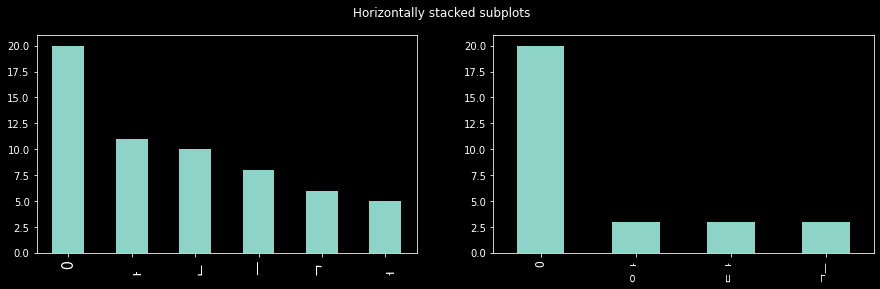

In [35]:
chunk_dir = 'data/korean-single-speaker/kss_chunks'

def k_ax(ax, **kwargs):
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=k_prop, rotation=90, **kwargs)

# chunk_progress_df = pd.read_csv(f'{base_dir}/chunk_progress.csv')
# chunk_df = pd.read_csv(f'{base_dir}/chunk.csv')
# print(chunk_df)
def filter_counts(df, val):
    counts = df.value_counts()
    return counts[counts>val]
    # return counts[counts[col]>val]

# df['a'].value_counts()[df['a'].value_counts()>2]
chunk_char_df = pd.read_csv(f'{chunk_dir}/chunk_char.csv')
chunk_syl_df = pd.read_csv(f'{chunk_dir}/chunk_syl.csv')
# display(gt_keep(chunk_char_df['char'], 4))

# k_plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Horizontally stacked subplots')
k_ax(ax1, size=16)
k_ax(ax2, size=12)
filter_counts(chunk_char_df['char'], 4).plot(kind='bar', ax=ax1)
filter_counts(chunk_syl_df['syl'], 2).plot(kind='bar', ax=ax2)
display(chunk_char_df)
display(chunk_syl_df)